In [1317]:
import os.path
import pandas as pd
import urllib.parse
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import csv
import statsmodels.api as sm
import statsmodels.graphics as smg
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy.stats

In [750]:
active_listings = pd.read_csv('~/Desktop/K2_DataScience/K2_Project2/Zillow_Analysis_Salt_Lake_City/zillow_analysis_notebooks/zillow_slc_current_listings_processed.csv',
                             index_col=0)

historical_listings = pd.read_csv('~/Desktop/K2_DataScience/K2_Project2/Zillow_Analysis_Salt_Lake_City/zillow_analysis_notebooks/zillow_slc_historic_prices_processed.csv',
                             index_col=0).reset_index(drop=True)

In [751]:
# only keep data that I want to do stats and modeling on
active_listings_filtered = active_listings.drop(labels=['title', 'address', 'city', 'state', 'facts and features', 'url'], axis =1)

# create data frame with NaN removed
active_listings_filtered.dropna(inplace=True)

In [1102]:
# this display option will make it easier to see price data
pd.options.display.float_format = '{:20,.2f}'.format

In [753]:
# change postal code type to string since it is a categorical feature

format_post_codes = active_listings_filtered['postal_code']
format_post_codes = format_post_codes.astype('str')
active_listings_filtered.drop(labels='postal_code', axis=1)
active_listings_filtered['postal_code'] = format_post_codes

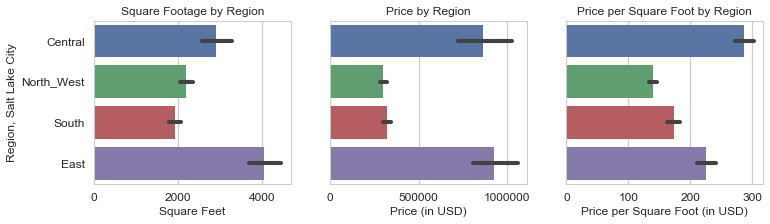

In [755]:
#plotting square footage by region
fig = plt.figure(figsize=[12,3])
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)

fig.add_subplot(131)   #left
ax = sns.barplot(y="region", x="sqft", data=active_listings_filtered)
plt.xlabel('Square Feet', fontsize=12)
plt.ylabel('Region, Salt Lake City', x=2, fontsize=12)
plt.title('Square Footage by Region', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)

#plotting price by region
fig.add_subplot(132)   #middle
ax = sns.barplot(y="region", x="price", data=active_listings_filtered)
plt.xlabel('Price (in USD)', fontsize=12)
ax.get_yaxis().set_visible(False)
plt.title('Price by Region', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)

#plotting price per square foot by region
fig.add_subplot(133)   #right
ax = sns.barplot(y="region", x="price_per_sqft", data=active_listings_filtered)
plt.xlabel('Price per Square Foot (in USD)', fontsize=12)
ax.get_yaxis().set_visible(False)
plt.title('Price per Square Foot by Region', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)

plt.show()

## Are differences in size and price statistically significant for the different geographic groups?

These plots suggest that there are differences in the property values and home size for geographic subsets. Are these differences statistically significant? 

To address this question I calculated and plotted pairwise Tukey HSD tests given a set of geographic and numeric parameters. These tests establish a confidence interval to compare the means of all pairs within a given group and establish whether two groups are statistically different (i.e. 'reject' the null hypothesis that the groups are not different). I also directly calculated p-values for these pairs so that I could assign numeric significance to the relationship; note that p-value can be determined from the Tukey statistics but this approach was more straight foward. 

**Findings**

Many post codes are statistically different from one another by price, size, and price_per_sqft. One obvious outlier is 84103, which is significantly more expensive than other zip codes (pvalue=0.00012). There are too many statistically significant differences too make generalized conclusions however, so next let’s consider the broader ‘neighborhood’ subset for these metrics.

These data show the Cottonwood, Emigration Canyon, and Downtown SLC neighborhoods are significantly more expensive than the Murry, South SLC, Taylorsville_Midvale, and West Valley neighborhoods. Homes in the Cottonwood neighborhood are significantly larger than homes in all neighborhoods except Emigration Canyon. Homes in Downtown SLC are statistically more expensive per square foot than all neighborhoods except Emigration Canyon, and homes in the mid-value neighborhood os South Salt Lake are significantly more expensive per square foot than homes in the low-value neighborhoods of Taylorsville_Midvale and West Valley.

As with the zip code analysis, these metrics are hard to interpret unless you are familiar with these neighborhood categories. To gain a higher level view, I performed these same analyses using the ‘region’ cut of the data. The region analysis shows that homes in Central and East Salt Lake City are priced at significantly higher values than homes in the North-West or South parts of the city. The size and price per square foot values are significantly different across all geographic categories. 

As my analyses decreased in granualrity (going from zipcode, to neighborhood, to region) the differences in property value and size became more apperant. An interesting way to visualize this is to look through the Tukey plots generated by these different cuts of data. For the zipcode analysis, the is a great deal of overlap in the Tukey intervals and it's hard to distinguish a trend. A trend becomes clearer in the neighborhood data, with low-value and high-value neighborhoods appearing in the data. The coarsest cut of the data, region, shows very distinct differences in price, size, and price per square foot, indicating that these regions do represent statistically distinct property segments for these metrics.   

In [756]:
import scipy.stats as stats
import math
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [759]:
# define a function to plot confidence intervals for mean metric value for data given a certain cut
def summarize_tukey(data, cuts, metrics):
    for cut in cuts:
        for metric in metrics:
            print('Tukey\'s HSD test for {} and {}'.format(cut, metric))
            t = pairwise_tukeyhsd(endog=data[metric], groups=data[cut], alpha=0.05)
            print(t.summary())

In [761]:
import csv

# define a function that will identify only statistically significant differences between categories
# based on Tukey's HSD of a for a given data set, data cut, and numeric metric
def summarize_tukey_significant(data, cuts, metrics):
    for cut in cuts:
        for metric in metrics:
            print('\nTukey\'s HSD test for {} and {}'.format(cut, metric))
            t = pairwise_tukeyhsd(endog=data[metric], groups=data[cut], alpha=0.05)
            data_as_csv = t._results_table.as_csv()
            for row in csv.reader(data_as_csv.split("\n")):
                if len(row) > 4 and row[5] == 'True  ':
                    print(row[0]+" "+row[1]+" "+row[5])

In [762]:
# run summarize_tukey on listings cut by geography and size type and compare price, size, and price per sqft    
cut_list = ['postal_code', 'neighborhood', 'region']
metric_list = ['price', 'sqft', 'price_per_sqft']

summarize_tukey_significant(active_listings_filtered, cut_list, metric_list)


Tukey's HSD test for postal_code and price
84103  84106  True  
84103  84107  True  
84103  84111  True  
84103  84115  True  
84103  84118  True  
84103  84119  True  
84103  84120  True  
84103  84123  True  
84103  84128  True  
84103  84129  True  
84106  84121  True  
84107  84121  True  
84108  84119  True  
84115  84121  True  
84117  84119  True  
84118  84121  True  
84119  84121  True  
84120  84121  True  
84121  84123  True  
84121  84128  True  
84121  84129  True  

Tukey's HSD test for postal_code and sqft
84101  84103  True  
84101  84108  True  
84101  84117  True  
84101  84121  True  
84101  84124  True  
84102  84121  True  
84103  84106  True  
84103  84111  True  
84103  84115  True  
84103  84118  True  
84103  84119  True  
84103  84123  True  
84104  84121  True  
84105  84121  True  
84106  84108  True  
84106  84117  True  
84106  84121  True  
84107  84121  True  
84108  84111  True  
84108  84119  True  
84109  84121  True  
84111  84117  True  
84111  841

In [763]:
# define a function to plot confidence intervals for mean metric value for data given a certain cut
def plot_tukey(data, cuts, metrics):
    for cut in cuts:
        for metric in metrics:
            pairwise_tukeyhsd(endog=data[metric], groups=data[cut], alpha=0.05).plot_simultaneous(figsize=(4, 4))
            plt.title('Tukey\'s HSD test for {} and {}'.format(cut, metric))

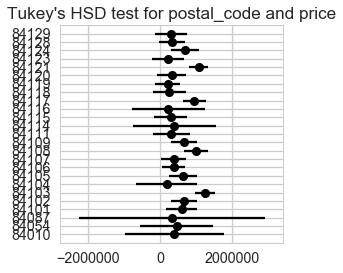

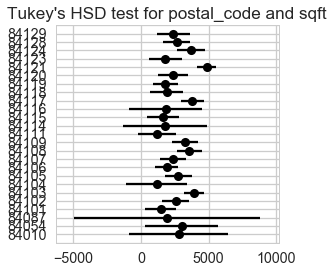

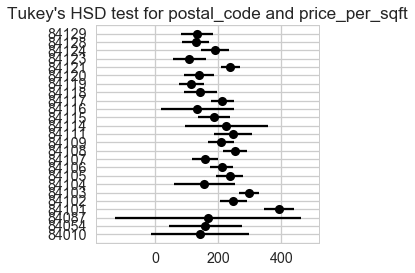

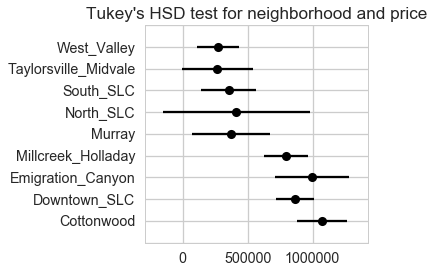

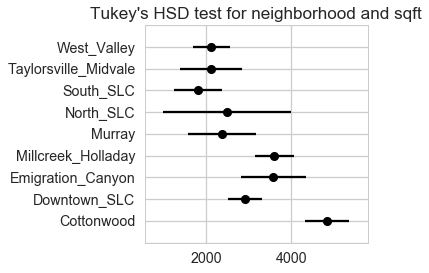

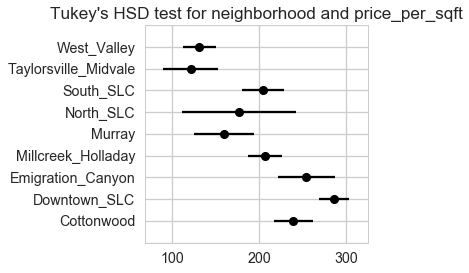

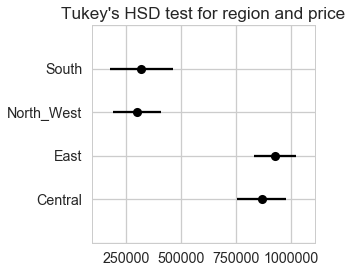

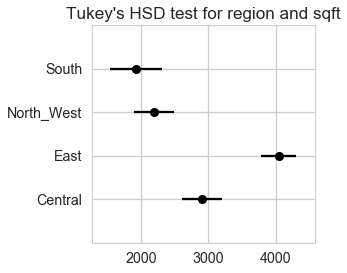

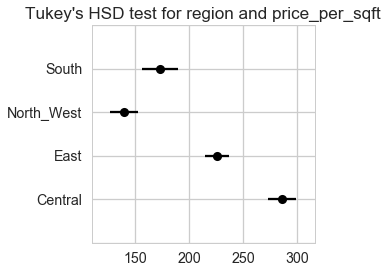

In [764]:
# run plot_tukey on listings cut by geography and size type and compare price, size, and price per sqft    
cut_list = ['postal_code', 'neighborhood', 'region']
metric_list = ['price', 'sqft', 'price_per_sqft']
              
plot_tukey(active_listings_filtered, cut_list, metric_list)

In [765]:
# create a function to perform pairwise two tailed t-test on
# a given data set, data cut, and metric
def calc_pval(data, cut, metric):
    cut_list = data[cut].unique()
    for n in range(len(cut_list)):
        data_cut_1 = data[data[cut] == cut_list[n]]
        for m in range(1,len(cut_list)):
            data_cut_2 = data[data[cut] == cut_list[m]]
            if n!=m:
                t1 = stats.ttest_ind(a= data_cut_1[metric],
                            b= data_cut_2[metric],
                            equal_var=False)
                print('p-val =', t1[1], 'for {}, {}'.format(cut_list[n], cut_list[m]))

In [766]:
# run p-val calcs by region and price
calc_pval(active_listings_filtered, 'region', 'price')

p-val = 7.39280781124e-12 for Central, North_West
p-val = 3.3601817749e-11 for Central, South
p-val = 0.555512412442 for Central, East
p-val = 0.253306097696 for North_West, South
p-val = 2.52769585027e-17 for North_West, East
p-val = 0.253306097696 for South, North_West
p-val = 2.04377101338e-16 for South, East
p-val = 2.52769585027e-17 for East, North_West
p-val = 2.04377101338e-16 for East, South


In [767]:
# run p-val calcs by neighborhood and price
calc_pval(active_listings_filtered, 'neighborhood', 'price')

p-val = 6.96211253048e-13 for Downtown_SLC, West_Valley
p-val = 3.88029699432e-10 for Downtown_SLC, South_SLC
p-val = 1.59780933444e-08 for Downtown_SLC, Murray
p-val = 0.609505759227 for Downtown_SLC, Emigration_Canyon
p-val = 0.480287418829 for Downtown_SLC, Millcreek_Holladay
p-val = 1.26822474439e-06 for Downtown_SLC, North_SLC
p-val = 0.157921847858 for Downtown_SLC, Cottonwood
p-val = 1.5837515754e-12 for Downtown_SLC, Taylorsville_Midvale
p-val = 3.35387323284e-06 for West_Valley, South_SLC
p-val = 0.00659907015455 for West_Valley, Murray
p-val = 0.00508610774837 for West_Valley, Emigration_Canyon
p-val = 2.99720716349e-12 for West_Valley, Millcreek_Holladay
p-val = 0.00790500819638 for West_Valley, North_SLC
p-val = 6.29337630365e-09 for West_Valley, Cottonwood
p-val = 0.857540516815 for West_Valley, Taylorsville_Midvale
p-val = 3.35387323284e-06 for South_SLC, West_Valley
p-val = 0.588469746317 for South_SLC, Murray
p-val = 0.0121508389925 for South_SLC, Emigration_Canyon
p-va

In [768]:
#individually calculate the p-value in price difference between 84103 and all other listings

def specific_p_calc(location, cut, metric, data):
    data_specific = data[data[cut] == location]
    data_remainder = data[data[cut] != location]
    t1 = stats.ttest_ind(a= data_specific[metric],
                            b= data_remainder[metric],
                            equal_var=False)
    print('the p-value for {} compared to all other {} is'.format(location, cut), t1[1])

In [769]:
specific_p_calc('North_West', 'region', 'price_per_sqft', active_listings_filtered)

the p-value for North_West compared to all other region is 2.24348031052e-48


# Comparison of comps based between regions

In [770]:
active_listings_filtered.head()

,postal_code,price,beds,baths,sqft,price_per_sqft,neighborhood,region,size_type
zpid,,,,,,,,,
2090375808,84101,"265,000.00",1.00,1.00,753.00,351.93,Downtown_SLC,Central,small
2090452983,84101,"245,000.00",1.00,1.00,763.00,321.10,Downtown_SLC,Central,small
83826154,84101,"319,900.00",1.00,1.00,893.00,358.23,Downtown_SLC,Central,small
65733953,84101,"268,850.00",1.00,1.00,750.00,358.47,Downtown_SLC,Central,small
65729920,84101,"419,000.00",2.00,2.00,"1,160.00",361.21,Downtown_SLC,Central,small


In [771]:
small_urban = active_listings_filtered[(active_listings_filtered['size_type']=='small') & 
                                      (active_listings_filtered['region']=='Central')]

large_urban = active_listings_filtered[(active_listings_filtered['size_type']=='large') & 
                                      (active_listings_filtered['region']!='Central')]

stats.ttest_ind(a= small_urban['price_per_sqft'],
                            b= large_urban['price_per_sqft'],
                            equal_var=False)

Ttest_indResult(statistic=7.13276026588672, pvalue=2.1996703434656663e-09)

In [520]:
# FINISH THIS FUNCTION! IT WILL CALC IF COMPS ARE PRICED DIFFERENTLY

def comp_calculator(geo_cut, comp_var, data): # geo cut is a geographic parameter, comp_var is a size or bedroom variable
    geo_cut_list = data[geo_cut].unique() 
    comp_var_list = list(data[comp_var].unique())
    geo_comp_perms = {k:v for k,v in zip(geo_cut_list, [comp_var_list]*len(geo_cut_list))}
    for geo,comp in geo_comp_perms.items():
        print(geo,comp)

In [521]:
comp_calculator('region', 'beds', active_listings_filtered)

Central [1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 5.0, 10.0, 8.0, 9.0]
North_West [1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 5.0, 10.0, 8.0, 9.0]
South [1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 5.0, 10.0, 8.0, 9.0]
East [1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 5.0, 10.0, 8.0, 9.0]


## Linear Regression of Model

In [1120]:
# look at correlations between variables
acorr = active_listings_filtered.corr()

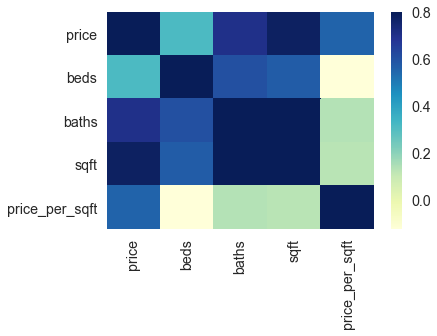

In [1121]:
sns.heatmap(acorr, vmax=0.8, cmap="YlGnBu")

In [936]:
# create price model containing all data 
price_removed = active_listings_filtered.columns
price_removed = price_removed.drop('price')

formula = 'price ~ ' + ' + '.join(price_removed)

In [937]:
# create price model containing all data 

price_results_all = sm.OLS.from_formula(formula, active_listings_filtered).fit()
price_results_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     136.2
Date:                Fri, 04 May 2018   Prob (F-statistic):          1.26e-274
Time:                        14:03:31   Log-Likelihood:                -10705.
No. Observations:                 756   AIC:                         2.147e+04
Df Residuals:                     725   BIC:                         2.162e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                            -7.418e+05   5.62e+04    -13.191      0.000   -8.52e+05   -6.31e+05
postal_code[T.84054]                 -1.156e+05   2.56e+05     -0.452      0.651   -6.17e+05    3.86e+05
postal_code[T.84087]                 -8408.0757   4.06e+05     -0.021      0.983   -8.05e+05    7.88e+05
postal_code[T.84101]                  -3.81e+05   6.41e+04     -5.943      0.000   -5.07e+05   -2.55e+05
postal_code[T.84102]                  1.442e+04   5.52e+04      0.261      0.794    -9.4e+04    1.23e+05
postal_code[T.84103]                  1.599e+04    4.2e+04      0.381      0.703   -6.64e+04    9.84e+04
postal_code[T.84104]                  5.169e+04   1.18e+05      0.439      0.661    -1.8e+05    2.83e+05
postal_code[T.84105]                  -399.9242   5.65e+04     -0.007      0.994   -1.11e+05     1.1e+05
postal_code[T.84106]                 -9.099e+04   4.17e+04     -2.180      0.030   -1.73e+05   -9045.496
postal_code[T.84107]                 -3.786e+04    4.1e+04     -0.923      0.356   -1.18e+05    4.26e+04
postal_code[T.84108]                 -1.137e+04   2.41e+04     -0.472      0.637   -5.86e+04    3.59e+04
postal_code[T.84109]                 -4.319e+04   4.66e+04     -0.926      0.355   -1.35e+05    4.84e+04
postal_code[T.84111]                    2.4e+04   7.41e+04      0.324      0.746   -1.21e+05    1.69e+05
postal_code[T.84114]                  -1.53e+05   2.68e+05     -0.571      0.568   -6.79e+05    3.73e+05
postal_code[T.84115]                 -8492.0331   4.92e+04     -0.173      0.863   -1.05e+05    8.82e+04
postal_code[T.84116]                  1.252e+04   1.36e+05      0.092      0.927   -2.55e+05     2.8e+05
postal_code[T.84117]                  5.933e+04   4.18e+04      1.419      0.156   -2.27e+04    1.41e+05
postal_code[T.84118]                 -5259.0861   7.27e+04     -0.072      0.942   -1.48e+05    1.38e+05
postal_code[T.84119]                  9.315e+04   5.89e+04      1.582      0.114   -2.24e+04    2.09e+05
postal_code[T.84120]                 -5.316e+04    6.8e+04     -0.781      0.435   -1.87e+05    8.04e+04
postal_code[T.84121]                 -2.159e+05   3.07e+04     -7.029      0.000   -2.76e+05   -1.56e+05
postal_code[T.84123]                  8.762e+04   5.46e+04      1.603      0.109   -1.97e+04    1.95e+05
postal_code[T.84124]                 -4.077e+04   4.97e+04     -0.821      0.412   -1.38e+05    5.68e+04
postal_code[T.84128]                 -8.572e+04   6.18e+04     -1.388      0.166   -2.07e+05    3.55e+04
postal_code[T.84129]                 -6.237e+04    5.4e+04     -1.156      0.248   -1.68e+05    4.36e+04
neighborhood[T.Downtown_SLC]         -3.269e+05   3.12e+04    -10.493      0.000   -3.88e+05   -2.66e+05
neighborhood[T.Emigration_Canyon]    -

In [953]:
# create price model containing only size and features 

price_onlyspecs_results = sm.OLS.from_formula('price ~ beds + baths + sqft', active_listings_filtered).fit()

In [954]:
price_onlyspecs_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     442.7
Date:                Fri, 04 May 2018   Prob (F-statistic):          1.27e-165
Time:                        14:20:23   Log-Likelihood:                -11036.
No. Observations:                 756   AIC:                         2.208e+04
Df Residuals:                     752   BIC:                         2.210e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.874e+04   5.83e+04      1.352      0.177   -3.56e+04    1.93e+05
beds        -1.35e+05   1.74e+04     -7.759      0.000   -1.69e+05   -1.01e+05
baths       7.702e+04   2.77e+04      2.783      0.006    2.27e+04    1.31e+05
sqft         287.2264     17.748     16.184      0.000     252.385     322.068
==============================================================================
Omnibus:                      856.437   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           168403.325
Skew:                           5.048   Prob(JB):                         0.00
Kurtosis:                      75.417   Cond. No.                     1.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [955]:
# plotting coefficients with error bars for model

# extract information about the model for plotting
price_onlyspecs_results.params

price_onlyspecs_results.conf_int()

# calculate error bars from confidence limits

err_bar = price_onlyspecs_results.params - price_onlyspecs_results.conf_int()[0]

# create df with coefficents and error values; here I only wanted 'size' parameters so I sliced
coef_df = pd.DataFrame({'coef': price_onlyspecs_results.params.values[1:],
                        'err': err_bar.values[1:],
                        'varname': err_bar.index.values[1:]
                       })

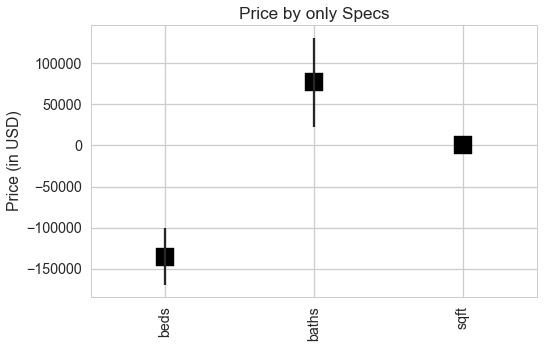

In [956]:
# plot coefficient with error bar for each size type

fig, ax = plt.subplots(figsize=(8, 5))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=None)
ax.set_ylabel('Price (in USD)', x=8)
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=300, 
           y=coef_df['coef'], color='black')
plt.title('Price by only Specs')
plt.show()

In [985]:
# plotting residuals

pred_val = price_onlyspecs_results.fittedvalues.copy()
true_val = active_listings_filtered['price'].values.copy()
residual = true_val - pred_val

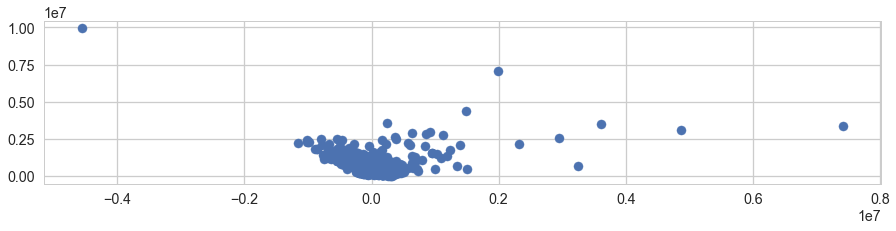

In [988]:
fig, ax = plt.subplots(figsize=(15,3))
_ = ax.scatter(residual, pred_val)

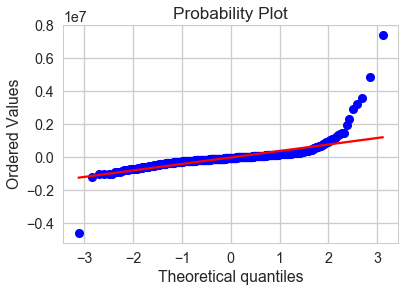

In [1002]:
# plotting probability of residual data against the theoretical quantiles for normal distribution
# some deviations from normality but somewhat okay

import scipy as sp
fig, ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(residual, plot=ax, fit=True)
plt.show()

In [780]:
# create zip code dummy variables
active_listings_zip_dummies = pd.get_dummies(active_listings_filtered, columns=['postal_code'])

dummy_list = (active_listings_zip_dummies.columns).drop(['price', 'neighborhood', 'region', 'price_per_sqft', 'size_type'])
dummy_formula = 'price ~ ' + ' + '.join(dummy_list)

In [781]:
price_dummy_zip_results = sm.OLS.from_formula(dummy_formula, active_listings_zip_dummies).fit()

In [782]:
price_dummy_zip_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     53.13
Date:                Fri, 04 May 2018   Prob (F-statistic):          3.54e-152
Time:                        10:34:02   Log-Likelihood:                -11009.
No. Observations:                 756   AIC:                         2.207e+04
Df Residuals:                     728   BIC:                         2.220e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3138.7903   6.46e+04      0.049      0.961   -1.24e+05     1.3e+05
beds              -1.099e+05   1.82e+04     -6.032      0.000   -1.46e+05   -7.41e+04
baths              6.841e+04   2.83e+04      2.419      0.016    1.29e+04    1.24e+05
sqft                281.5232     17.980     15.658      0.000     246.225     316.822
postal_code_84010 -7.523e+04   2.91e+05     -0.258      0.796   -6.47e+05    4.97e+05
postal_code_84054 -2.182e+05   2.26e+05     -0.964      0.335   -6.62e+05    2.26e+05
postal_code_84087 -6.073e+04   5.03e+05     -0.121      0.904   -1.05e+06    9.27e+05
postal_code_84101  2.708e+05   1.06e+05      2.562      0.011    6.33e+04    4.78e+05
postal_code_84102  1.331e+05   9.21e+04      1.444      0.149   -4.78e+04    3.14e+05
postal_code_84103  2.933e+05   6.67e+04      4.401      0.000    1.62e+05    4.24e+05
postal_code_84104   3.85e+04   1.93e+05      0.199      0.842   -3.41e+05    4.18e+05
postal_code_84105  1.064e+05   9.37e+04      1.136      0.257   -7.75e+04     2.9e+05
postal_code_84106  2.785e+04   7.77e+04      0.359      0.720   -1.25e+05     1.8e+05
postal_code_84107 -1.152e+05   8.81e+04     -1.308      0.191   -2.88e+05    5.77e+04
postal_code_84108  1.891e+05   8.46e+04      2.236      0.026     2.3e+04    3.55e+05
postal_code_84109 -4.518e+04    8.8e+04     -0.514      0.608   -2.18e+05    1.28e+05
postal_code_84111  9.624e+04   1.27e+05      0.758      0.449   -1.53e+05    3.46e+05
postal_code_84114  5.198e+04   2.52e+05      0.206      0.837   -4.44e+05    5.48e+05
postal_code_84115  4.333e+04    1.1e+05      0.394      0.694   -1.73e+05    2.59e+05
postal_code_84116 -4.922e+04   2.26e+05     -0.218      0.828   -4.93e+05    3.95e+05
postal_code_84117  5.118e+04   7.68e+04      0.667      0.505   -9.96e+04    2.02e+05
postal_code_84118 -1.673e+04   1.12e+05     -0.149      0.882   -2.37e+05    2.04e+05
postal_code_84119 -6.928e+04   8.42e+04     -0.823      0.411   -2.35e+05    9.61e+04
postal_code_84120 -7.894e+04   1.03e+05     -0.770      0.442    -2.8e+05    1.22e+05
postal_code_84121 -7.071e+04   6.61e+04     -1.070      0.285      -2e+05    5.91e+04
postal_code_84123 -9.894e+04   1.12e+05     -0.884      0.377   -3.19e+05    1.21e+05
postal_code_84124 -1.012e+05   9.57e+04     -1.056      0.291   -2.89e+05    8.68e+04
postal_code_84128 -2.104e+05   8.98e+04     -2.342      0.019   -3.87e+05    -3.4e+04
postal_code_84129 -8.869e+04    1.1e+05     -0.805      0.421   -3.05e+05    1.28e+05
==============================================================================
Omnibus:                      896.467   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           188568.790
Skew:                           5.476   Prob(JB):                         0.00
Kurtosis:      

In [967]:
# look for significant variables
price_dummy_zip_results.pvalues[price_dummy_zip_results.pvalues<0.05]

beds                                0.00
baths                               0.02
sqft                                0.00
postal_code_84101                   0.01
postal_code_84103                   0.00
postal_code_84108                   0.03
postal_code_84128                   0.02
dtype: float64

As we found before, there is too much granularity in the zip code data. The just a few zip codes have significant p-values, including 84103 which we already identified as being significantly more expensive than all other zip codes. Let's try the dummy approach with 'region'.

In [1324]:
# create region dummy variables
active_listings_region_dummies = pd.get_dummies(active_listings_filtered, columns=['region', 'size_type'])

dummy_list = (active_listings_region_dummies.columns).drop(['price', 'neighborhood', 'postal_code', 'price_per_sqft'])
dummy_formula = 'price ~ ' + ' + '.join(dummy_list)

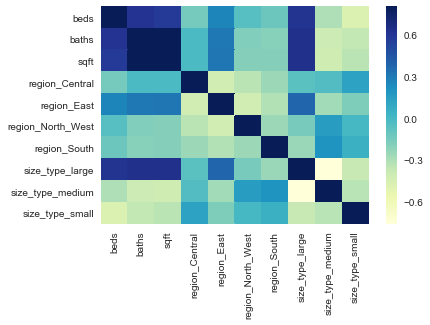

In [1332]:
acorr = active_listings_region_dummies.drop(['price', 'neighborhood', 'postal_code', 'price_per_sqft'], axis=1).corr()
sns.heatmap(acorr, vmax=0.8, cmap="YlGnBu")

In [1323]:
# fit to model with region as dummy
price_dummy_region_results = sm.OLS.from_formula(dummy_formula, active_listings_region_dummies).fit()
# model summary
price_dummy_region_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     236.3
Date:                Mon, 07 May 2018   Prob (F-statistic):          4.98e-169
Time:                        19:37:53   Log-Likelihood:                -11019.
No. Observations:                 756   AIC:                         2.205e+04
Df Residuals:                     749   BIC:                         2.208e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.228e+04   4.63e+04      0.913      0.361   -4.86e+04    1.33e+05
beds              -1.184e+05   1.73e+04     -6.841      0.000   -1.52e+05   -8.44e+04
baths               6.81e+04   2.72e+04      2.504      0.012    1.47e+04    1.21e+05
sqft                283.6382     17.500     16.208      0.000     249.283     317.993
region_Central     1.955e+05   3.44e+04      5.678      0.000    1.28e+05    2.63e+05
region_East       -1.355e+04   3.58e+04     -0.378      0.705   -8.39e+04    5.68e+04
region_North_West -1.101e+05   3.52e+04     -3.126      0.002   -1.79e+05    -4.1e+04
region_South      -2.957e+04   4.11e+04     -0.719      0.472    -1.1e+05    5.12e+04
==============================================================================
Omnibus:                      904.438   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           201109.721
Skew:                           5.545   Prob(JB):                         0.00
Kurtosis:                      82.129   Cond. No.                     3.77e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.71e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1075]:
# plotting coefficients with error bars for including region

# extract information about the model for plotting
price_dummy_region_results.params

price_dummy_region_results.conf_int()

# calculate error bars from confidence limits

err_bar = price_dummy_region_results.params - price_dummy_region_results.conf_int()[0]

# create df with coefficents and error values; here I only wanted 'region' parameters so I sliced
coef_df = pd.DataFrame({'coef': price_dummy_region_results.params.values[4:8],
                        'err': err_bar.values[4:8],
                        'varname': err_bar.index.values[4:8]
                       })

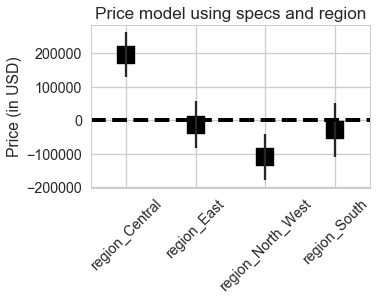

In [1076]:
# plot coefficient with error bar for price modeled with specs and region

fig, ax = plt.subplots(figsize=(5,3))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=None)
ax.set_ylabel('Price (in USD)', x=8)
ax.set_xlabel('')
ax.set
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=300, 
           y=coef_df['coef'], color='black')
ax.set_xticklabels(labels=coef_df['varname'], rotation=45 )
plt.title('Price model using specs and region')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
plt.show()

Above, I've plotted the region coefficients for the linear regression model for price using bed, baths, size, and region as the independant variables. Neither East nor South coefficients were statistically significant, but the effect of being located Central or North_West is pretty clear.

Humm, the only region variables that seem significant are Central and North_West. Being in the central region has a positive effect on price (coef = 195,500) and being in the North_West region has a negative effect on price (coef = -110,100). Being in neither the East nor South region has an impact on price, likely because of many other variable associated with pricing. Maybe we can add the size_type variable to the mix and see what this does.

In [1083]:
# create size_type and region dummy variables
dummies = pd.get_dummies(active_listings_filtered, columns=['region', 'size_type'])

dummy_list = (dummies.columns).drop(['price', 'neighborhood', 'postal_code', 'price_per_sqft', 'baths', 'sqft'])
dummy_formula = 'price_per_sqft ~ ' + ' + '.join(dummy_list)
print(dummy_formula)

price_per_sqft ~ beds + region_Central + region_East + region_North_West + region_South + size_type_large + size_type_medium + size_type_small


In [1084]:
# fit price to dummy variables for size_type and region
dummy_results = sm.OLS.from_formula(dummy_formula, dummies).fit()

#summarize price
dummy_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_per_sqft   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     43.95
Date:                Fri, 04 May 2018   Prob (F-statistic):           4.28e-46
Time:                        16:03:36   Log-Likelihood:                -4526.0
No. Observations:                 756   AIC:                             9066.
Df Residuals:                     749   BIC:                             9098.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           154.5460      7.475     20.675      0.000     139.872     169.220
beds                 -9.8821      3.391     -2.914      0.004     -16.539      -3.226
region_Central      115.0536      6.286     18.303      0.000     102.713     127.394
region_East          64.5238      6.366     10.136      0.000      52.027      77.020
region_North_West   -27.7001      6.530     -4.242      0.000     -40.519     -14.881
region_South          2.6686      7.878      0.339      0.735     -12.796      18.133
size_type_large      47.8179      8.631      5.540      0.000      30.875      64.761
size_type_medium     43.8694      5.443      8.060      0.000      33.184      54.554
size_type_small      62.8587      7.548      8.328      0.000      48.041      77.677
==============================================================================
Omnibus:                      607.528   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20640.486
Skew:                           3.327   Prob(JB):                         0.00
Kurtosis:                      27.718   Cond. No.                     7.02e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.6e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Most significant set of features contributing to price per square foot beds + region_Central + region_East + region_North_West + region_South + size_type_large + size_type_medium + size_type_small.

In [1117]:
# plotting residuals

pred_val = dummy_results.fittedvalues.copy()
true_val = active_listings_filtered['price_per_sqft'].values.copy()
residual = true_val - pred_val

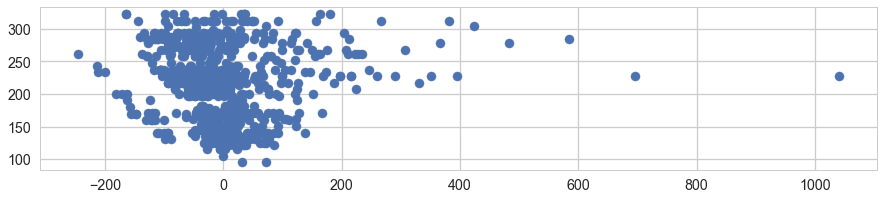

In [1118]:
fig, ax = plt.subplots(figsize=(15,3))
_ = ax.scatter(residual, pred_val)

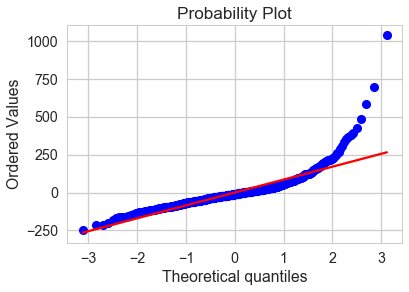

In [1119]:
# plotting probability of residual data against the theoretical quantiles for normal distribution
# some deviations from normality but somewhat okay

import scipy as sp
fig, ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(residual, plot=ax, fit=True)
plt.show()

In [1085]:
# plotting coefficients with error bars for including region

# extract information about the model for plotting
dummy_results.params

dummy_results.conf_int()

# calculate error bars from confidence limits

err_bar = dummy_results.params - dummy_results.conf_int()[0]

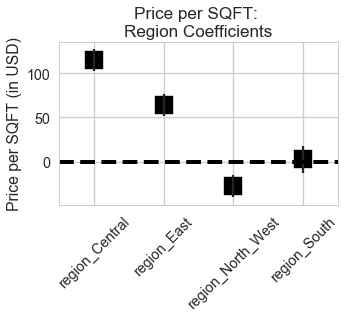

In [1086]:
# create df with coefficents and error values; here I only wanted 'region' parameters so I sliced
coef_df = pd.DataFrame({'coef': dummy_results.params.values[2:6],
                        'err': err_bar.values[2:6],
                        'varname': err_bar.index.values[2:6]
                       })

# plot coefficient with error bar for price modeled with specs and region

fig, ax = plt.subplots(figsize=(5,3))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=None)
ax.set_ylabel('Price per SQFT (in USD)', x=8)
ax.set_xlabel('')
ax.set
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=300, 
           y=coef_df['coef'], color='black')
ax.set_xticklabels(labels=coef_df['varname'], rotation=45 )
plt.title('Price per SQFT: \nRegion Coefficients')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
plt.show()

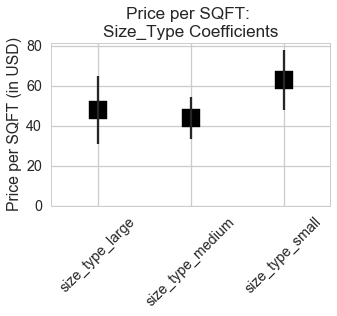

In [1087]:
# create df with coefficents and error values; here I only wanted 'size' parameters so I sliced
coef_df = pd.DataFrame({'coef': dummy_results.params.values[6:],
                        'err': err_bar.values[6:],
                        'varname': err_bar.index.values[6:]
                       })

# plot coefficient with error bar for price modeled with specs and region

fig, ax = plt.subplots(figsize=(5,3))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=None)
ax.set_ylabel('Price per SQFT (in USD)', x=8)
ax.set_xlabel('')
ax.set
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=300, 
           y=coef_df['coef'], color='black')
ax.set_xticklabels(labels=coef_df['varname'], rotation=45 )
plt.title('Price per SQFT: \nSize_Type Coefficients')
plt.show()

In [1116]:
# calculating predictions

# values predicted with model
small_central_pred = 154.55 + (115.05)*1 + 62.86*1
large_central_pred = 154.55 + (115.05)*1 + 47.82*1
large_nw_pred = 154.55 + (-27.70)*1 + 47.82*1

#
small_central_act = active_listings_filtered[(active_listings_filtered['region']=='Central') & 
                         (active_listings_filtered['size_type']=='small')]['price_per_sqft'].mean()

large_central_act = active_listings_filtered[(active_listings_filtered['region']=='Central') & 
                         (active_listings_filtered['size_type']=='large')]['price_per_sqft'].mean()

large_nw_act = active_listings_filtered[(active_listings_filtered['region']=='North_West') & 
                         (active_listings_filtered['size_type']=='large')]['price_per_sqft'].mean()

print('The predicted price per sqft for a small central home is ${0:.2f} and the actual price per sqft is ${1:.2f}'.
      format(small_central_pred, small_central_act))

print('The predicted price per sqft for a large central home is ${0:.2f} and the actual price per sqft is ${1:.2f}'.
      format(large_central_pred, large_central_act))

print('The predicted price per sqft for a large north western home is ${0:.2f} and the actual price per sqft is ${1:.2f}'.
      format(large_nw_pred, large_nw_act))

The predicted price per sqft for a small central home is $332.46 and the actual price per sqft is $323.01
The predicted price per sqft for a large central home is $317.42 and the actual price per sqft is $275.54
The predicted price per sqft for a large north western home is $174.67 and the actual price per sqft is $127.98


Above I modeled the price per square foot using the predictors of 'size_type' and 'region'. It's clear from the data that most of these factors are significant for determining price, but the linear regression model isn't a great fit for the data. With the exception of sqft and 'region_South', all of these factors are statistically significant for determining price per sqft. The R^2 of this model, however, isn't great. R^2 of 0.290 means that only 29% of the variation in the data can be explained by the relationship between these factors. I also modeled the 'size_type' relationship with 'neighborhoods', and found a similar relationship for price_per_sqft.

Real estate pricing is complex, but even an oversimplified model for the data can yield some important insights. All other variables being equal, the listed price per square foot of a home in the Central and East neighborhoods is boosted (by \$115.05 /sqft and \$64.52/sqft, respectively) and depressed by being in the North_West neighborhoods (by \$27.70/sqft). The effect of being in the South neighborhoods was not statistically significant in this model, and I became curious about how the data for the South neighborhoods differs from that of the other three neighborhoods.

## Measures of Variability

Perhaps homes in the South neighborhoods are more heterogeneious, and are therefore harder to classify and predict with a simple regression model? I explored the idea that the diversity of homes in a given region might differ  hypothesis by calculating the relative standard deviation (RSD) in listing price for comparable homes within a given region. For these purposes comparable homes were defined as the having same number of bedrooms.

I found that the RSD of homes listed in the 'South' region are significantly lower than those in the other three regions. 

In [1235]:
# calculating relative standard deviation (or coefficient of variation) for comparable listings by region

region_bed_mean = active_listings_filtered.groupby(['region', 'beds'])['price'].mean()
region_bed_std = active_listings_filtered.groupby(['region', 'beds'])['price'].std()
region_bed_rsd = (100*(region_bed_std/region_bed_mean)).reset_index(drop=False)
region_bed_rsd.columns = ['region', 'beds', 'rsd']

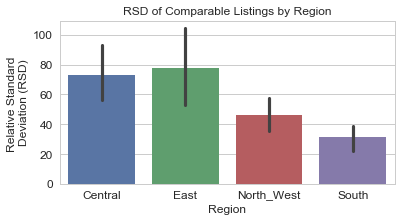

In [1236]:
# plotting relative standard deviation for comparable listings by region

fig = plt.figure(figsize=[6,3])
sns.set_style("whitegrid")
sns.set_context("notebook")

ax = sns.barplot(y="rsd", x="region", data=region_bed_rsd[region_bed_rsd['beds'] <=8])
plt.xlabel('Region', fontsize=12)
plt.ylabel('Relative Standard \nDeviation (RSD)', x=2, fontsize=12)
plt.title('RSD of Comparable Listings by Region', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.show()

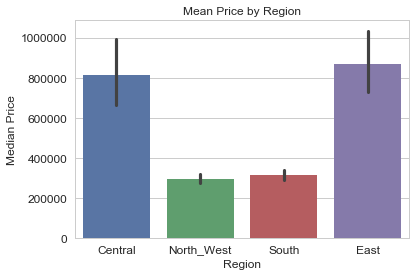

In [1205]:
ax = sns.barplot(y="price", x="region", data=active_listings_filtered[active_listings_filtered['beds'] <=5])
plt.xlabel('Region', fontsize=12)
plt.ylabel('Median Price', x=2, fontsize=12)
plt.title('Mean Price by Region', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.show()

In [1206]:
active_listings_filtered.groupby('region')['price'].mean()

region
Central                865,758.84
East                   926,170.66
North_West             301,464.55
South                  320,702.65
Name: price, dtype: float64

In [1234]:
active_listings_filtered.groupby(['region'])[['beds','sqft', 'baths']].std()

,beds,sqft,baths
region,,,
Central,1.62,"2,396.85",1.68
East,1.37,"3,072.09",1.85
North_West,1.19,"1,062.75",0.88
South,1.05,806.75,0.97


In [1215]:
region_bed_rsd.groupby(['region', 'beds', 'size_type'])['rsd'].mean()

region      beds   size_type
Central      1.00  medium                     51.96
                   small                      48.44
             2.00  large                      19.52
                   medium                     38.12
                   small                      40.94
             3.00  large                      52.35
                   medium                     60.73
                   small                        nan
             4.00  large                     104.65
                   medium                     23.58
             5.00  large                      89.73
                   medium                       nan
             6.00  large                      58.48
                   medium                       nan
             7.00  large                      48.58
            10.00  large                        nan
East         1.00  small                        nan
             2.00  large                      68.09
                   medium          

In [1303]:
import scipy.stats

groups_data = {}
groups = list(active_listings_filtered['region'].unique())
for group in groups:
    data = active_listings_filtered[active_listings_filtered['region']==group]['price'].reset_index(drop=True)
    groups_data[group] = data

In [1316]:

for items in list(itertools.combinations(groups, 2)):
    t = scipy.stats.levene(groups_data[items[0]], groups_data[items[1]], center='median')
    print('the p-value of {} and {} is'.format(items[0], items[1]), t[1])

the p-value of Central and North_West is 1.30981773216e-08
the p-value of Central and South is 4.0069347931e-06
the p-value of Central and East is 0.795570082379
the p-value of North_West and South is 0.552260330229
the p-value of North_West and East is 1.50196468797e-07
the p-value of South and East is 2.06249345571e-05


In [1293]:
groups = {'g1':g1, 'g2':g2}

t = scipy.stats.levene(groups['g1'], groups['g2'], center='median')
print(t)

LeveneResult(statistic=22.051991712526476, pvalue=4.0069347931018151e-06)
